In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
from pathlib import Path
# sys.path.insert(1, os.path.realpath(os.path.dirname(os.path.pardir)))

import numpy as np
import scipy
import matplotlib.pyplot as plt


import warnings
warnings.filterwarnings('ignore')

# os.environ["CUDA_VISIBLE_DEVICES"] = "6" #[PCH]

import torch
from torch import nn
from torch import functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
# from torchsummary import summary
import safetensors

from transformers import WhisperTokenizer, WhisperFeatureExtractor
from transformers import GenerationConfig
from transformers import WhisperForConditionalGeneration
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments

# import LORA modules
from peft import LoraConfig
from peft import LoraModel, AdaLoraModel, PeftModel, get_peft_model

from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler, QuantileTransformer

from dataclasses import dataclass
from typing import Any, Dict, List, Union

import evaluate
metric = evaluate.load("wer")

from pathlib import Path
# [PCH]
with open("../../default_paths.txt", 'r') as file:
    lines = file.readlines()
    data_path    = Path(lines[0].strip().split("=")[1])
    project_path = Path(lines[1].strip().split("=")[1])
    
utils_path = project_path / "utils"
train_path = data_path / "train"
test_path  = data_path / "test"
sys.path.insert(0, str(utils_path))

from data_utils_lesha import (process_all_files, #[pch]
process_string, 
save_sentences_to_txt,
load_sentences_from_txt,
ModelAdaptationConfig,
PreprocessConfig,
AugmentConfig,
configure_input_layers,
configure_learnable_layers,
WhisperAugmentDataset,
DataCollatorSpeechSeq2SeqWithPadding,
count_parameters, 
save_config, 
load_config)

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #[PCH]
device = 'cpu'

In [2]:
regularize_config = dict(apply_spec_augment=True,
                         mask_feature_prob=0.1,
                         mask_time_prob=0.1,
                         decoder_layerdrop=0.2, 
                         encoder_layerdrop=0.2,
                         dropout=0.1,
                         activation_dropout=0.1)


In [3]:
DATE_TO_INDEX = {'t12.2022.04.28': 0,
                't12.2022.05.05': 1,
                't12.2022.05.17': 2,
                't12.2022.05.19': 3,
                't12.2022.05.24': 4,
                't12.2022.05.26': 5,
                't12.2022.06.02': 6,
                't12.2022.06.07': 7,
                't12.2022.06.14': 8,
                't12.2022.06.16': 9,
                't12.2022.06.21': 10,
                't12.2022.06.23': 11,
                't12.2022.06.28': 12,
                't12.2022.07.05': 13,
                't12.2022.07.14': 14,
                't12.2022.07.21': 15,
                't12.2022.07.27': 16,
                't12.2022.07.29': 17,
                't12.2022.08.02': 18,
                't12.2022.08.11': 19,
                't12.2022.08.13': 20,
                't12.2022.08.18': 21,
                't12.2022.08.23': 22,
                't12.2022.08.25': 23}

def expand_tokenizer_model(tokenizer, model, new_tokens_list):
    date_info = new_tokens_list
    tokenizer.add_special_tokens(dict(additional_special_tokens=date_info))
    model.resize_token_embeddings(len(tokenizer))
    return tokenizer, model

In [4]:
""" LOAD PRETRAINED MODEL COMPONENTS """

# WHISPER_MODEL_NAME = "openai/whisper-large-v3" #[PCH]
WHISPER_MODEL_NAME = "openai/whisper-tiny"

# load feature/label processing engines|
feature_extractor = WhisperFeatureExtractor.from_pretrained(WHISPER_MODEL_NAME)
tokenizer = WhisperTokenizer.from_pretrained(WHISPER_MODEL_NAME, task="transcribe", language='en')
model = WhisperForConditionalGeneration.from_pretrained(WHISPER_MODEL_NAME, **regularize_config)

if ".en" not in WHISPER_MODEL_NAME:
    model.generation_config.language = "english"
    model.generation_config.task = "transcribe"
    model.generation_config.forced_decoder_ids = None

tokenizer, model = expand_tokenizer_model(tokenizer, model, list(DATE_TO_INDEX.keys()))


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [5]:
print(*model.generation_config.__dict__.keys(), sep='\n')

max_length
max_new_tokens
min_length
min_new_tokens
early_stopping
max_time
stop_strings
do_sample
num_beams
num_beam_groups
penalty_alpha
use_cache
temperature
top_k
top_p
min_p
typical_p
epsilon_cutoff
eta_cutoff
diversity_penalty
repetition_penalty
encoder_repetition_penalty
length_penalty
no_repeat_ngram_size
bad_words_ids
force_words_ids
renormalize_logits
constraints
forced_bos_token_id
forced_eos_token_id
remove_invalid_values
exponential_decay_length_penalty
suppress_tokens
begin_suppress_tokens
forced_decoder_ids
sequence_bias
guidance_scale
low_memory
watermarking_config
num_return_sequences
output_attentions
output_hidden_states
output_scores
output_logits
return_dict_in_generate
pad_token_id
bos_token_id
eos_token_id
encoder_no_repeat_ngram_size
decoder_start_token_id
num_assistant_tokens
num_assistant_tokens_schedule
cache_implementation
prompt_lookup_num_tokens
max_matching_ngram_size
generation_kwargs
_from_model_config
_commit_hash
transformers_version
alignment_heads
i

### Regularize

## Adapt model

In [6]:
lora_config = LoraConfig(r=8, 
                         task_type="SEQ_2_SEQ_LM", 
                         use_rslora=True, 
                         use_dora=True)

adaptation_config = ModelAdaptationConfig(fs_whisper=50, 
                                          inputs_stack="concat",
                                          conv1_time_kernel_size=9, 
                                          conv2_time_kernel_size=5,
                                          conv1_out_channels=1280, 
                                          conv_layer_idx_stride_2=2,
                                          adapt_model="full",  # full, freeze, lora
                                          freeze_modules=(), # conv, encoder, adapter, decoder, sanyafreeze
                                          low_rank_adaptation_modules=("decoder"), # encoder, decoder or full
                                          low_rank_adaptation_targets=("q_proj", "k_proj", "v_proj", "out_proj", "fc1", "fc2"), 
                                          lora_config=lora_config,
                                          n_electrodes=256, n_features=2, max_duration=30)

In [7]:
model = configure_input_layers(model, adaptation_config)

Input size:  torch.Size([10, 512, 1500])
Conv1 output size:  torch.Size([10, 1280, 1500])
Conv2 output size:  torch.Size([10, 384, 1500])

 Number of parameters conv1:
Conv1d(512, 1280, kernel_size=(9,), stride=(1,), padding=(4,))
Total: 5.90M, Trainable: 5.90M

Number of parameters conv2: 
Conv1d(1280, 384, kernel_size=(5,), stride=(1,), padding=(2,))
Total: 2.46M, Trainable: 2.46M


In [8]:
model = configure_learnable_layers(model, adaptation_config)
model

Full model parameters: 
Total: 45.59M, Trainable: 45.02M

Returning full model...


WhisperForConditionalGeneration(
  (model): WhisperModel(
    (encoder): WhisperEncoder(
      (conv1): Conv1d(512, 1280, kernel_size=(9,), stride=(1,), padding=(4,))
      (conv2): Conv1d(1280, 384, kernel_size=(5,), stride=(1,), padding=(2,))
      (embed_positions): Embedding(1500, 384)
      (layers): ModuleList(
        (0-3): 4 x WhisperEncoderLayer(
          (self_attn): WhisperSdpaAttention(
            (k_proj): Linear(in_features=384, out_features=384, bias=False)
            (v_proj): Linear(in_features=384, out_features=384, bias=True)
            (q_proj): Linear(in_features=384, out_features=384, bias=True)
            (out_proj): Linear(in_features=384, out_features=384, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=384, out_features=1536, bias=True)
          (fc2): Linear(in_features=1536, out_features=384, bias=True)
       

## Load previous checkpoint

In [8]:
prev_experiment_path = data_path / "experiments" / WHISPER_MODEL_NAME / "GRADUAL_STEP2_encoder"
checkpoint_path = prev_experiment_path / "checkpoint-4400"

weights1 = safetensors.torch.load_file(checkpoint_path / "model-00001-of-00002.safetensors")
weights2 = safetensors.torch.load_file(checkpoint_path / "model-00002-of-00002.safetensors")
weights = {**weights1, **weights2}

model.load_state_dict(weights, strict=False)
model.set_output_embeddings(model.get_input_embeddings())
count_parameters(model)

Total: 1552.17M, Trainable: 1550.25M


(1552174080, 1550254080)

## Unfreeze next module

In [9]:
#model.model.freeze_encoder()

# # unfreeze encoder
# for p_name, p in model.model.encoder.named_parameters():
#     p.requires_grad = True


# # unfreeze adapter
# for p_name, p in model.model.decoder.named_parameters():
#     if "encoder" in p_name:
#         p.requires_grad = True


# # unfreeze everything
# for p_name, p in model.model.decoder.named_parameters():
#     if "encoder" in p_name:
#         p.requires_grad = True


# sanyafreeze
# sanyafreeze
for param in model.model.decoder.embed_tokens.parameters():
    param.requires_grad = False

for param in model.model.decoder.embed_positions.parameters():
    param.requires_grad = False

for param in model.proj_out.parameters():
    param.requires_grad = False

count_parameters(model)

Total: 45.59M, Trainable: 24.92M


(45592064, 24918656)

## Load data and scale dataset

In [10]:
%%time
data_train = process_all_files(train_path)
data_test = process_all_files(test_path)

print(data_train.keys())

XV = np.concatenate(data_train['voltage_list'], axis=0)
# scalerV = RobustScaler(quantile_range=(0.01, 0.99), unit_variance=True).fit(XV)
#scalerV = QuantileTransformer(n_quantiles=3000, output_distribution='uniform', subsample=30000).fit(XV)
scalerV = StandardScaler().fit(XV)

XS = np.concatenate(data_train['spike_list'], axis=0)
scalerS = MinMaxScaler(feature_range=(-1, 1)).fit(XS)

XV, XS = None, None

dict_keys(['voltage_list', 'spike_list', 'sentence_list', 'date_list'])
CPU times: total: 26.3 s
Wall time: 27.2 s


## Define train and eval datasets with augmentations

In [11]:
check_augments = False
n_train = 100 if check_augments else len(data_train['voltage_list'])

preprocess_config = PreprocessConfig(inputs_stack=adaptation_config.inputs_stack,
                                     voltage_scaler=scalerV, 
                                     spike_scaler=scalerS, 
                                     sentence_tokenizer=tokenizer,
                                     eval_filter_freq=15,
                                     filter_voltage=True,
                                     filter_spikes=False,
                                     fs_orig=50,  
                                     fs_whisper=adaptation_config.fs_whisper,
                                     max_duration=30.0,
                                     resample_type='interpolate')

augment_config = AugmentConfig(total_augment_probability=0.5, 
                               channel_mask_probability=0.1,
                               channel_mask_fraction_limits=(0.01, 0.10),
                               time_mask_probability=0.1,
                               time_mask_fraction_limits=(0.02, 0.1),
                               time_stretch_probability=0, 
                               time_stretch_limits=(0.95, 1.05),
                               voltage_noise_probability=0.5,
                               voltage_noise_snr_limits=(8, 20),
                               voltage_drift_limits=(-0.5, 0.5),
                               spike_noise_probability=0.5,
                               spike_noise_per_bin_probability=0.01,
                               no_filter_probability=0.7,
                               filter_cutoff_freq_limits=(preprocess_config.eval_filter_freq, 25),
                               random_signal_shift_probability=0.7)


train_dataset = WhisperAugmentDataset(data_train['voltage_list'][:n_train], 
                                           data_train['spike_list'][:n_train], 
                                           data_train['sentence_list'][:n_train],
                                           preprocess_config, 
                                           augment_config, 
                                           is_eval=False,
                                           date_list=data_train['date_list'])


eval_dataset = WhisperAugmentDataset(data_test['voltage_list'], 
                                           data_test['spike_list'], 
                                           data_test['sentence_list'],
                                           preprocess_config, 
                                           augment_config, 
                                           is_eval=True,
                                           date_list=data_test['date_list'])

Processing dataset...: 100%|██████████| 8780/8780 [00:11<00:00, 739.72it/s] 


Input processing time ~ 16.2 ms


Processing dataset...: 100%|██████████| 880/880 [00:05<00:00, 173.65it/s]


Input processing time ~ 6.0 ms


Original shape (256, 591)
0
the eastern coast is a place for pure pleasure and excitement


torch.Size([512, 1500])

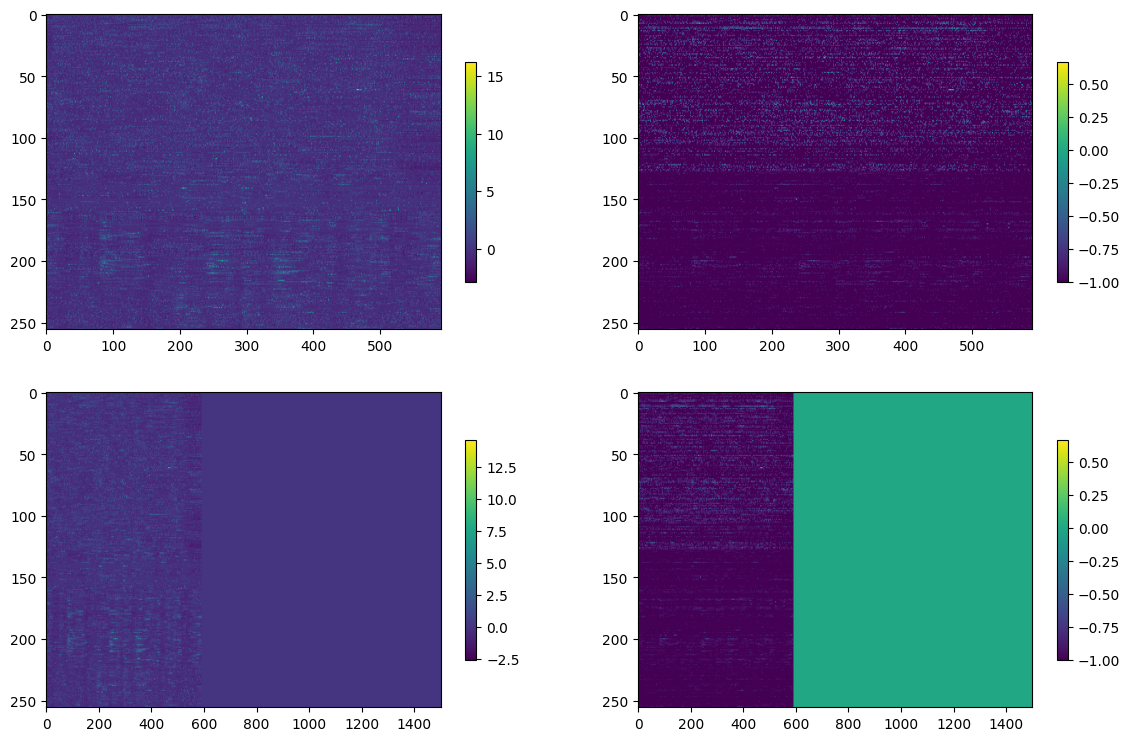

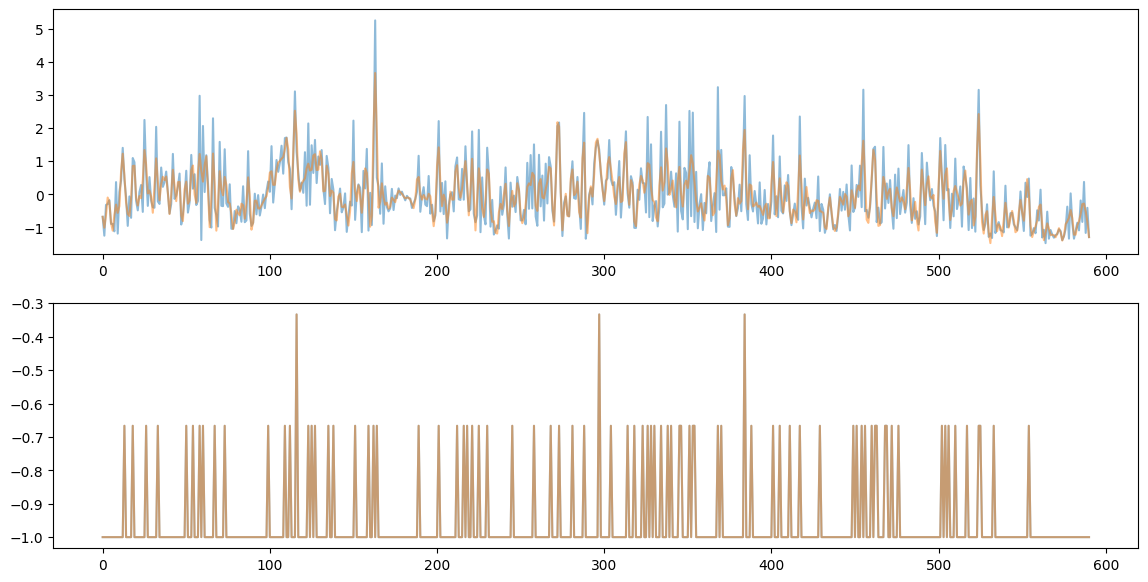

In [13]:
idx = 10
chan = 3

step = 1 if adaptation_config.fs_whisper == 50 else 2

dataset = train_dataset
data = data_train

voltage = scalerV.transform(data['voltage_list'][idx]).T
spikes = scalerS.transform(data['spike_list'][idx]).T

print("Original shape", voltage.shape)

plt.figure(figsize=(14, 9))

# with scaling
plt.subplot(221)
plt.imshow(voltage, aspect='auto')
plt.colorbar(shrink=0.7)

plt.subplot(222)
plt.imshow(spikes, aspect='auto')
plt.colorbar(shrink=0.7)

# Augmentations etc.
input_features = dataset[idx]['input_features'].numpy()
if adaptation_config.inputs_stack == "concat":
    cfg = adaptation_config
    new_input_features = np.empty((cfg.n_electrodes, cfg.n_features, (cfg.max_duration * cfg.fs_whisper)))
    new_input_features[:, 0, :] = input_features[:cfg.n_electrodes, :]
    new_input_features[:, 1, :] = input_features[cfg.n_electrodes:, :]
    input_features = new_input_features

start_idx = np.arange(input_features.shape[-1] - 1)[(np.diff(np.sum(np.abs(input_features[:, 0, :]), axis=0)) > 0)][0]
start_idx = 0 if start_idx == 2 else start_idx
print(start_idx)
    
plt.subplot(223)
plt.imshow(input_features[:, 0], aspect='auto')
plt.colorbar(shrink=0.7)

plt.subplot(224)
plt.imshow(input_features[:, 1], aspect='auto')
plt.colorbar(shrink=0.7)


plt.figure(figsize=(14, 7))

plt.subplot(211)
plt.plot(voltage[chan], alpha=0.5)
plt.plot(input_features[chan, 0, start_idx:start_idx+voltage.shape[1]:step], alpha=0.5)


plt.subplot(212)
plt.plot(spikes[chan], alpha=0.5)
plt.plot(input_features[chan, 1, start_idx:start_idx+voltage.shape[1]:step], alpha=0.5)
print(data_train['sentence_list'][idx])
dataset[0]['input_features'].shape

## Training setup

### Setup wandb and hugging face login

## Set training parameters

In [13]:
import wandb
# wandb.login(key="84800673dd80a5eac8bb77b02728e733f806fd10")

experiment_path = data_path / "experiments" / WHISPER_MODEL_NAME / "GRADUAL_FULL_dropout"
experiment_path.mkdir(parents=True, exist_ok=True)


config_names = ["augment_config.json", "preprocess_config.json", "adaptataion_config.json"]
configs = [augment_config, preprocess_config, adaptation_config]

# for i in range(len(config_names)):
#     save_config(configs[i], experiment_path / config_names[i])

batch_size = 16
epoch_length = int(len(train_dataset) / batch_size)

training_args = Seq2SeqTrainingArguments(
    output_dir=experiment_path,  # change to a repo name of your choice
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps=int(16 / batch_size),  # increase by 2x for every 2x decrease in batch size
    learning_rate=2.5e-5,
    weight_decay=1e-3,
    num_train_epochs=12,
    warmup_steps=1 * epoch_length,
    gradient_checkpointing=True,
    fp16=False,
    evaluation_strategy="steps",
    per_device_eval_batch_size=batch_size,
    predict_with_generate=True,
    generation_max_length=32,
    save_steps=int(epoch_length / 2),
    eval_steps=int(epoch_length / 2),
    logging_steps=int(epoch_length / 16),
    report_to=["wandb"],
    load_best_model_at_end=True,
    metric_for_best_model="wer",
    greater_is_better=False,
    push_to_hub=False,
)

# initialize data collator
data_collator = DataCollatorSpeechSeq2SeqWithPadding(
    tokenizer=tokenizer,
    feature_extractor=feature_extractor,
    decoder_start_token_id=model.config.decoder_start_token_id,
)

# defining here because using a concerete tokenizer instance! 
def compute_metrics(pred):
    pred_ids = pred.predictions
    label_ids = pred.label_ids

    # replace -100 with the pad_token_id
    label_ids[label_ids == -100] = tokenizer.pad_token_id

    # we do not want to group tokens when computing the metrics
    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    label_str = tokenizer.batch_decode(label_ids, skip_special_tokens=True)

    wer = 100 * metric.compute(predictions=pred_str, references=label_str)

    return {"wer": wer}

# initialize trainer
trainer = Seq2SeqTrainer(
    args=training_args,
    model=model,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    # tokenizer=feature_extractor, #[PCH]
    tokenizer=tokenizer,
)

wandb: Currently logged in as: altime. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/atimcenko/.netrc
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


## Train

In [ ]:
trainer.train()

## Test Date Tokens

In [99]:
# defining here because using a concerete tokenizer instance! 
def compute_metrics(pred):
    pred_ids = pred.predictions
    label_ids = pred.label_ids
    print(f'{pred_ids=}')
    print(f'{label_ids=}')
    # replace -100 with the pad_token_id
    label_ids[label_ids == -100] = tokenizer.pad_token_id
    print(f'{label_ids=}')
    # we do not want to group tokens when computing the metrics
    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    label_str = tokenizer.batch_decode(label_ids, skip_special_tokens=True)
    print(f'{pred_str=}')
    print(f'{label_str=}')
    wer = 100 * metric.compute(predictions=pred_str, references=label_str)

    return {"wer": wer}

kek = 't12.2022.04.28'
love = 'i love you'
@dataclass
class Pred(object):
    predictions = torch.tensor(tokenizer.batch_encode_plus([kek + love, kek + love]).input_ids)
    label_ids = torch.tensor(tokenizer.batch_encode_plus([kek + love, kek + love]).input_ids)
pred = Pred()    

In [104]:
tokenizer.batch_decode(model.generate(torch.zeros(1, 512, 1500)))

['<|startoftranscript|><|en|><|transcribe|><|notimestamps|> What?<|endoftext|>']

In [116]:
tokenizer.batch_encode_plus([kek, kek], return_tensors='pt').input_ids[:, :-1]

tensor([[50258, 50259, 50359, 50363, 51865],
        [50258, 50259, 50359, 50363, 51865]])

In [ ]:
tokenizer.batch_encode_plus([kek, kek]).input_ids

In [124]:
tokenizer.batch_decode(model.generate(torch.randn(2, 512, 1500), decoder_input_ids=tokenizer.batch_encode_plus([kek, kek], return_tensors='pt').input_ids[:, :-1]))

['<|startoftranscript|><|en|><|transcribe|><|notimestamps|>t12.2022.04.28�<|endoftext|>',
 '<|startoftranscript|><|en|><|transcribe|><|notimestamps|>t12.2022.04.28�<|endoftext|>']

In [107]:
pred.label_ids

tensor([[50258, 50259, 50359, 50363, 51865,    72,   959,   291, 50257],
        [50258, 50259, 50359, 50363, 51865,    72,   959,   291, 50257]])

In [100]:
pred.label_ids, pred.predictions

(tensor([[50258, 50259, 50359, 50363, 51865,    72,   959,   291, 50257],
         [50258, 50259, 50359, 50363, 51865,    72,   959,   291, 50257]]),
 tensor([[50258, 50259, 50359, 50363, 51865,    72,   959,   291, 50257],
         [50258, 50259, 50359, 50363, 51865,    72,   959,   291, 50257]]))

In [101]:
tokenizer.batch_decode(pred.label_ids), tokenizer.batch_decode(pred.predictions)

(['<|startoftranscript|><|en|><|transcribe|><|notimestamps|>t12.2022.04.28i love you<|endoftext|>',
  '<|startoftranscript|><|en|><|transcribe|><|notimestamps|>t12.2022.04.28i love you<|endoftext|>'],
 ['<|startoftranscript|><|en|><|transcribe|><|notimestamps|>t12.2022.04.28i love you<|endoftext|>',
  '<|startoftranscript|><|en|><|transcribe|><|notimestamps|>t12.2022.04.28i love you<|endoftext|>'])

In [102]:
tokenizer.batch_decode(pred.label_ids, skip_special_tokens=True), tokenizer.batch_decode(pred.predictions, skip_special_tokens=True)

(['<|startoftranscript|><|en|><|transcribe|><|notimestamps|>i love you',
  '<|startoftranscript|><|en|><|transcribe|><|notimestamps|>i love you'],
 ['<|startoftranscript|><|en|><|transcribe|><|notimestamps|>i love you',
  '<|startoftranscript|><|en|><|transcribe|><|notimestamps|>i love you'])

In [103]:
compute_metrics(pred)

pred_ids=tensor([[50258, 50259, 50359, 50363, 51865,    72,   959,   291, 50257],
        [50258, 50259, 50359, 50363, 51865,    72,   959,   291, 50257]])
label_ids=tensor([[50258, 50259, 50359, 50363, 51865,    72,   959,   291, 50257],
        [50258, 50259, 50359, 50363, 51865,    72,   959,   291, 50257]])
label_ids=tensor([[50258, 50259, 50359, 50363, 51865,    72,   959,   291, 50257],
        [50258, 50259, 50359, 50363, 51865,    72,   959,   291, 50257]])
pred_str=['<|startoftranscript|><|en|><|transcribe|><|notimestamps|>i love you', '<|startoftranscript|><|en|><|transcribe|><|notimestamps|>i love you']
label_str=['<|startoftranscript|><|en|><|transcribe|><|notimestamps|>i love you', '<|startoftranscript|><|en|><|transcribe|><|notimestamps|>i love you']


{'wer': 0.0}

In [20]:
batch_tokens_test = tokenizer.batch_encode_plus(['t12.2022.04.28' + 'i love you', 't12.2022.04.28' + 'i love you'])

In [23]:
batch_tokens_test.input_ids

[[50258, 50359, 50363, 51865, 72, 959, 291, 50257],
 [50258, 50359, 50363, 51865, 72, 959, 291, 50257]]

In [25]:
tokenizer.batch_decode(batch_tokens_test.input_ids, skip_special_tokens=True)

['<|startoftranscript|><|transcribe|><|notimestamps|>i love you',
 '<|startoftranscript|><|transcribe|><|notimestamps|>i love you']

`use_cache = True` is incompatible with gradient checkpointing. Setting `use_cache = False`...


Step,Training Loss,Validation Loss,Wer
275,4.109500,1.043473,46.871590
550,3.303200,1.253293,51.418698
825,2.373700,1.165425,46.744271
1100,2.005100,1.051519,42.597308
1375,1.666300,0.925514,37.486359


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 448, 'begin_suppress_tokens': [220, 50257]}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 448, 'begin_suppress_tokens': [220, 50257]}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead.

### Evaluate from checkpoint

In [ ]:
experiment_path

In [ ]:
checkpoint_path = experiment_path / "checkpoint-1375"
model = WhisperForConditionalGeneration.from_pretrained(checkpoint_path).to('cuda')

In [ ]:
for idx in range(0, 10):
    true_text = data_test['sentence_list'][idx]
    print(f"True: {true_text}")
    input_tensor = train_dataset[idx]['input_features'].to('cuda').type(torch.float).reshape((1, 512, 3000))
    ids = model.generate(input_tensor).cpu()
    pred_text = tokenizer.decode(ids[0], skip_special_tokens=True)
    print(f"Pred: {pred_text}\n")

**Change num_beans**

In [ ]:
for idx in range(20, 30):
    true_text = sentences_test[idx]
    print(f"True: {true_text}")
    input_tensor = eval_dataset[idx]['input_features'].to('cuda').type(torch.float).reshape((1, 80, 3000))
    ids = model.generate(input_tensor).cpu()
    pred_text = tokenizer.decode(ids[0], skip_special_tokens=True)
    print(f"Pred: {pred_text}\n")

In [ ]:
model

In [ ]:
model.encoder